In [1]:
import pandas as pd
import datacq
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [2]:
from pyproj import Transformer
transformer = Transformer.from_crs(crs_from=4326, crs_to=31370)

In [3]:
stationsDF_full = datacq.STATIONS_METADF
stationsDF_full.Longitude = pd.to_numeric(stationsDF_full.Longitude)
stationsDF_full.Latitude = pd.to_numeric(stationsDF_full.Latitude)
stationsDF = stationsDF_full[['Latitude', 'Longitude', 'AirQualityStationType',
                            'AirQualityStationArea']].copy()
stationsDF['type'] = (stationsDF['AirQualityStationType'] +
                        ' - '+stationsDF['AirQualityStationArea'])
stationsDF['x'], stationsDF['y'] = transformer.transform(stationsDF['Latitude'], stationsDF['Longitude'])

In [4]:
stations = stationsDF.index.unique()
station_types = list(set(stationsDF.type))
startYear = 2013
endYear = 2020
years = range(startYear,endYear+1)
print(len(stations))

75


In [5]:
# Retrieve all PM2.5 time series and combine into one df
dfs_PM25 = []
for stat in tqdm(stations):
    df_stat = datacq.eea.get_df(years, stat, ['PM2.5'], verbose=False)
    if len(df_stat)!=0:
        df_stat.columns = [stat]
        dfs_PM25.append(df_stat)
df_25_all = pd.concat(dfs_PM25, axis=1)

100%|██████████| 75/75 [01:56<00:00,  1.55s/it]


In [15]:
# Remove stations with to many nans
max_nan_ratio = 0.1
df_25 = df_25_all.loc[:, (df_25_all.isna().sum()/len(df_25_all) <= max_nan_ratio)]
n_removed = len(df_25_all.columns)-len(df_25.columns)
print(f"Total number of stations: {len(df_25_all.columns)}")
print(f"Removed {n_removed} stations with {max_nan_ratio*100}% or more nans")
print("Number of stations left: ", len(df_25.columns))
#sorted(df_25.columns)

Total number of stations: 67
Removed 35 stations with 10.0% or more nans
Number of stations left:  32


<Figure size 432x288 with 0 Axes>

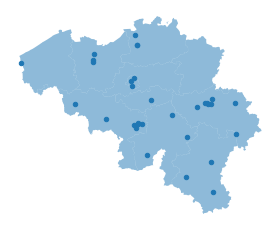

75


In [16]:
stations_PM25 = list(df_25)
stationsDF_pol = stationsDF.loc[stations_PM25]
# Shape files Belgium:
    #https://www.atlas-belgique.be/index.php/en/resources/map-data/

bel = gpd.read_file('data/shapefiles/provinces_L72.shp')

plt.figure()
bel.plot(alpha=0.5)
stationsDF_pol.plot.scatter(x='x', y='y', ax = plt.gca())
plt.axis('off')
plt.savefig('../figures/PM25_stations.png')
plt.show()
print(len(stations))

In [19]:
stationsDF_pol[stationsDF_pol.type=='industrial - rural']

Latitude  Longitude AirQualityStationType AirQualityStationArea  \
stationCode                                                                     
BELSA04      51.313929   4.403868            industrial                 rural   
BETR731      51.124691   3.739504            industrial                 rural   

                           type              x              y  
stationCode                                                    
BELSA04      industrial - rural  152447.999717  222679.000309  
BETR731      industrial - rural  105946.999729  201811.000310

In [17]:
stationsDF_pol = stationsDF.loc[stations_PM25]
counts = (stationsDF_pol.groupby('AirQualityStationType')['AirQualityStationArea']
                    .value_counts()
                    .unstack(fill_value=0))
counts['total'] = counts.sum(axis=1)
counts.loc['total'] = counts.sum()
counts.columns.name = 'Area'
counts.index.name = 'Type'
print(counts.style.to_latex(hrules=True, sparse_columns=True))
counts

\begin{tabular}{lrrrr}
\toprule
Area & rural & suburban & urban & total \\
Type &  &  &  &  \\
\midrule
background & 10 & 9 & 5 & 24 \\
industrial & 2 & 4 & 0 & 6 \\
traffic & 0 & 0 & 2 & 2 \\
total & 12 & 13 & 7 & 32 \\
\bottomrule
\end{tabular}



Area        rural  suburban  urban  total
Type                                     
background     10         9      5     24
industrial      2         4      0      6
traffic         0         0      2      2
total          12        13      7     32

/usr/local/Caskroom/miniconda/base/envs/PM/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


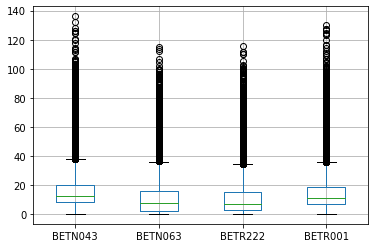

In [125]:
stype = station_types[2]
stats = [s for s in df_25.columns if stationsDF.loc[s,'type']==stype]
stations = ['BETN043', 'BETN063', 'BETR222', 'BETR001']
df_25[stations].boxplot()


In [34]:
stationsDF_pol
# Define pollutants
pollutants = ["SO2", "NO2", "CO", "O3", "PM2.5", "PM10"]
pol_dicts = datacq.eea.retrieveNbCodeDict(pollutants)
for p in pollutants:
    stationsDF_pol[p] = [s in pol_dicts[p] for s in stationsDF_pol.index]

In [36]:
stationsDF_pol[stationsDF_pol.AirQualityStationType=='traffic']

Latitude  Longitude AirQualityStationType AirQualityStationArea  \
stationCode                                                                     
BETR702      51.040689   3.734971               traffic                 urban   
BETR802      51.209519   4.431792               traffic                 urban   

                        type              x              y    SO2   NO2  \
stationCode                                                               
BETR702      traffic - urban  105549.999728  192469.000312  False  True   
BETR802      traffic - urban  154404.999715  211064.000313  False  True   

                CO     O3  PM2.5  PM10  
stationCode                             
BETR702      False  False   True  True  
BETR802       True  False   True  True

### Clustering

In [130]:
means = []
sigs = []
stations_PM10 = stationsDF.loc[df_25.columns]
for stat in stations_PM10.index:
    pm10_log = np.log(1+df_25[stat])
    mu, sig = norm.fit(pm10_log[(~pm10_log.isna()) & (pm10_log>=1)])
    means.append(mu)
    sigs.append(sig)
stations_PM10['mu'] = means
stations_PM10['sig'] = sigs

In [131]:
fg = sns.FacetGrid(data=stations_PM10, hue='type', aspect=1.61)
fg.map(plt.scatter, 'mu', 'sig').add_legend()